In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as PDEModel #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.models import AdjointSimpleODEModel as ODEModel #Model module builds basic pa
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# GPy: Gaussian processes library
import GPy

#GPyOpt
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,5) # lower time
xloc=np.linspace(2,8,5) # x locations
yloc=np.linspace(2,8,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

XGP= np.zeros((sensN*obsN,3))
XGP[:,0] = (X[:,0]+X[:,1])/2
XGP[:,1] = X[:,2]
XGP[:,2] = X[:,3] 



sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,9,5) # lower time
xloc=np.linspace(1.5,8.5,4) # x locations
yloc=np.linspace(1.5,8.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

XGPtest= np.zeros((sensN*obsN,3))
XGPtest[:,0] = (Xtest[:,0]+Xtest[:,1])/2
XGPtest[:,1] = Xtest[:,2]
XGPtest[:,2] = Xtest[:,3]

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

In [3]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(5, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
u=[]
u.append(np.ones(res)*wind) #x direction wind
u.append(np.ones(res)*0.0) # y direction wind

#u.append(np.ones(res)*0.1) #x direction wind
#u.append(np.ones(res)*0.1) # y direction wind
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source



In [4]:
sensWindX = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(m.u[0]).shape)
sensWindY = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(m.u[1]).shape)
xwind=np.asarray(m.u).take(sensWindX)
ywind=np.asarray(m.u).take(sensWindY)

XGPwind = np.c_[XGP,xwind,ywind]

sensWindX = np.ravel_multi_index(m.getGridCoord(XGPtest).transpose(), np.asarray(m.u[0]).shape)
sensWindY = np.ravel_multi_index(m.getGridCoord(XGPtest).transpose(), np.asarray(m.u[1]).shape)
xwind=np.asarray(m.u).take(sensWindX)
ywind=np.asarray(m.u).take(sensWindY)

XGPwindTest = np.c_[XGPtest,xwind,ywind]

In [5]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

### Inverse PDE

In [6]:
N_feat =1000 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,u=u,k_0=k_0,R=R) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

Calculating Adjoints...
124/125 
Calculating Phis...
999/1000 


### Inverse GP

In [7]:
kGP = GPy.kern.RBF(3, name="rbf")
mGP = GPy.models.GPRegression(XGP, yTrain[:,None], kGP)
mGP 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [8]:
#kGPwind = GPy.kern.RBF(3,active_dims=[0,1,2])*GPy.kern.RBF(2,active_dims=[3,4])
kGPwind = GPy.kern.RBF(5,ARD='true')
mGPwind = GPy.models.GPRegression(XGPwind, yTrain[:,None], kGPwind)
mGPwind 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,1.0,+ve,


### Model Optimisation

In [9]:
mGP.optimize()
mGP

GP_regression.,value,constraints,priors
rbf.variance,18.16433091466656,+ve,
rbf.lengthscale,4.990191064453969,+ve,
Gaussian_noise.variance,0.6639910602985112,+ve,


In [10]:
mGPwind.optimize()
mGPwind

GP_regression.,value,constraints,priors
rbf.variance,14.28722211781592,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,5.140417781811772e-06,+ve,


In [11]:
meanGP, covGP = mGP.predict_noiseless(XGPtest, full_cov=True)
meanGPwind, covGPwind = mGPwind.predict_noiseless(XGPwindTest, full_cov=True)

In [12]:
N_feat =200

k_02 = np.linspace(2,5,10)
MSE = np.zeros(len(k_02))
sources =[]
reps = 100
var = np.ones(len(yTest))*noiseSD**2
llObs = 0
k2 = EQ(2,2)
mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors,u=u,k_0=k_0,R=R) #initiate PDE model
def obj_funcLengthVarDiffReact(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    x3 = x[:, 2]
    x4 = x[:, 3]
    llObs = 0
    mPDE.sensormodel=sensors
    mPDE.kernel.l2=x1
    mPDE.kernel.sigma2=x2
    mPDE.k_0=x3
    mPDE.R=x4
    X1 = mPDE.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
    for j in range(reps):
        mPDE.sensormodel=sensors
        z = np.random.multivariate_normal(meanZ,covZ)
        source = mPDE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
        conc=mPDE.computeConcentration(source) # Compute test concentration
        mPDE.sensormodel=sensorsTest
        yInfer= mPDE.computeObservations() # Compute observations with noise
        llObs += -0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))

    llObs = llObs/reps
    return(-llObs)

In [13]:
bounds4d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0.1,10)},
            {'name': 'var_3', 'type': 'continuous', 'domain': (1e-5,1)},
            {'name': 'var_4', 'type': 'continuous', 'domain': (0,5)}]
maxiter = 50

myBopt_4d = GPyOpt.methods.BayesianOptimization(obj_funcLengthVarDiffReact, domain=bounds4d)
myBopt_4d.run_optimization(max_iter = maxiter)

Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculating Adjoints...
124/125 
Calculating Phis...
199/200 
Calculat

In [14]:
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_4d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_4d.fx_opt))     
print("="*20)

Value of (x,y) that minimises the objective:[1.00000000e+01 3.72325599e+00 1.00000000e-05 5.19070942e-01]
Minimum value of the objective: 4758.218695378463


In [15]:
mPDE.kernel.l2=myBopt_4d.x_opt[0]
mPDE.kernel.sigma2=myBopt_4d.x_opt[1]
mPDE.k_0=myBopt_4d.x_opt[2]
mPDE.R=myBopt_4d.x_opt[3]

mPDE.sensormodel=sensors
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

Calculating Adjoints...
124/125 
Calculating Phis...
199/200 


### Comparison

In [16]:
reps=100
llObsPDE=0
llObsGP=0
llObsGPwind=0
negPercent=0
var = np.ones(len(yTest))*noiseSD**2
for j in range(reps):
    #mPDE.sensormodel=sensors
    z = np.random.multivariate_normal(meanZPDE,covZPDE)
    source = mPDE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mPDE.computeConcentration(source) # Compute test concentration
    mPDE.sensormodel=sensorsTest
    yPDE= mPDE.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsPDE += -0.5*np.sum((np.square(np.subtract(yTest,yPDE))/var)+0.5*np.log(var))
    #mODE.sensormodel=sensors
    yGP = np.random.multivariate_normal(meanGP.flatten(),covGP)
    llObsGP += -0.5*np.sum((np.square(np.subtract(yTest,yGP))/var)+0.5*np.log(var))
    yGPwind = np.random.multivariate_normal(meanGPwind.flatten(),covGPwind)
    llObsGPwind += -0.5*np.sum((np.square(np.subtract(yTest,yGPwind))/var)+0.5*np.log(var))
llObsPDE = llObsPDE/reps
llObsGP = llObsGP/reps
llObsGPwind = llObsGPwind/reps

Results = pd.DataFrame([[llObsPDE],[llObsGP],[llObsGPwind]],columns=['Log like'],index=["PDE","GP", "GPwind"])


In [17]:
Results

,Log like
PDE,-4803.240030
GP,-10759.492175
GPwind,-3202.485329


In [18]:
source = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distribution
conc=mPDE.computeConcentration(source) # Compute test concentration
mPDE.sensormodel=sensorsTest
yPDE= mPDE.computeObservations(addNoise='TRUE')

In [19]:
X1, X2, X3, yGP2,yPDE2,yTest2,yGPwind2 = zip(*sorted(zip(XGPtest[:,0],XGPtest[:,1],XGPtest[:,2],meanGP,yPDE,yTest,meanGPwind)))

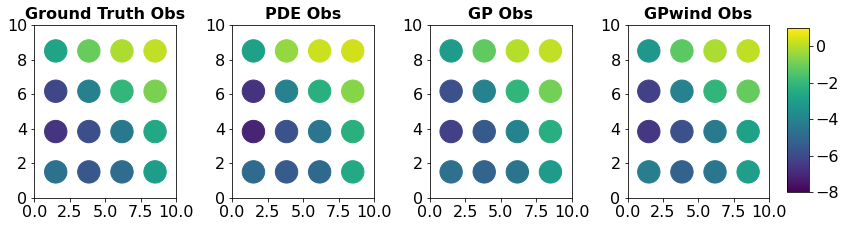

In [20]:
t0=0
t1=16
tconc=12

a=np.floor(np.min(concTrain[tconc],))
b=np.ceil(np.max(concTrain[tconc]))
plt.rcParams["figure.figsize"] = (15,4)
fig = plt.figure()


plt.subplot(1,4,1)
im1=plt.imshow(concTrain[tconc],origin='lower',extent=[0,10,0,10])
plt.title('Ground Truth Conc', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



ploti = 1
for title, data in zip(['Ground Truth Obs','PDE Obs', 'GP Obs','GPwind Obs'],[yTest2,yPDE2,yGP2,yGPwind2]):
    
    ploti+=1
    plt.subplot(1,5,ploti)
    im1=plt.scatter(X2[t0:t1],X3[t0:t1], s=500,c=data[t0:t1])
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.clim(a,b)
        
        
    tick_font_size = 16
        #if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 0.95])

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.99, 0.27, 0.02, 0.57])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()